# Assignment Week 9: House Price Regression using CNN

## Student ID: XXXXXXXX

In this lab we will show how to work with mixed data, also called multimodal learning, using deep learning. Mixed data is anything that is not just one type of data, such as mixing traditional structured data with images, or with audio, video, etc. The possibilities are endless!

We will compare a model using the structured data we have available, a model using only the images available and finally a model combining both inputs. This week's work may be too much for your personal computer to handle, so just work on a reduced sample if you see the process taking too much time. You can also just run the assignment in the cloud using either [Google Colab](https://colab.research.google.com/) or [Kaggle Kernels](https://www.kaggle.com/kernels), activiting a GPU environment (In Colab: Navigate to Editâ†’Notebook Settings and select GPU from the Hardware Accelerator drop-down. For Kaggle Kernels, [follow these instructions](https://www.kaggle.com/dansbecker/running-kaggle-kernels-with-a-gpu)).


## Packages

You will need to install the `pytorch` and `torchvision` packages.
To do so, I suggest starting a terminal by choosing File -> New -> Terminal from the JupyterLab menu, and running
`pip install torch torchvision`

In [16]:
from IPython.display import clear_output
from matplotlib import pyplot as plt
import collections
import numpy as np
import pandas as pd
from IPython.display import Image
import torch
import torchvision
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from torch.utils.data import Dataset
from sklearn.preprocessing import MinMaxScaler
from typing import Dict, Any
import os

%matplotlib inline

# To create the iterator
from itertools import product

# Live plotting
def live_plot(loss, train_acc, valid_acc=None, figsize=(7,5), title=''):
    clear_output(wait=True)
    fig, ax1 = plt.subplots(figsize=figsize)
    ax1.plot(loss, label='Training Loss', color='red')
    ax1.legend(loc='lower left')
    ax1.set_ylabel('Mean Square Error Loss')
    ax2 = ax1.twinx()
    ax2.plot(train_acc, label='Training MSE', color='green')
    if valid_acc is not None:
        ax2.plot(valid_acc, label='Validation MSE', color='blue')
    ax2.legend(loc='lower right')
    ax2.set_ylabel('MSE')
    ax2.set_xlabel('Epoch')
    plt.title(title)
    plt.show()

## Data Import and Preprocessing

The objective of the problem is to create a model that predicts house prices using the property's basic information (Bedrooms, bathrooms, area in sqft, zipcode) and a collage of four images in the house. Download the zip file from OWL and decompress it in the folder you are working on. Alternatively, you can run these lines of code if you are using Colab

In [9]:
# Download and unzip the data. Uncomment if you are using cloud environment.
!gdown https://drive.google.com/uc?id=1XZGDY0XVHNDawfMymX7d1BRO5a17KIN5
!unzip HousesDatasetClean.zip

'gdown' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.


The data has the following structured attributes, in the file ``HousesInfo.csv``:

- Number of bedrooms and bathrooms.
- Surface area of the house.
- Zipcode the house is located in (Categorical. We'll ignore it in this assignment.)
- **House price (target variable)**.

Run this code to load the data.

In [10]:
HouseData = pd.read_csv('HousesDatasetClean/HousesInfo.csv')
HouseData.drop(columns='zipcode', inplace=True)
HouseData.describe()

,bedrooms,bathrooms,area,price
count,535.000000,535.000000,535.000000,5.350000e+02
mean,3.377570,2.664953,2364.904673,5.893628e+05
std,1.160952,0.995077,1224.556982,5.090261e+05
min,1.000000,1.000000,701.000000,2.200000e+04
25%,3.000000,2.000000,1440.000000,2.492000e+05
50%,3.000000,2.500000,2078.000000,5.290000e+05
75%,4.000000,3.000000,3067.500000,7.285000e+05
max,10.000000,7.000000,9583.000000,5.858000e+06


And each element comes with a collage of four pictures representing different parts of the house. Here is an example. 

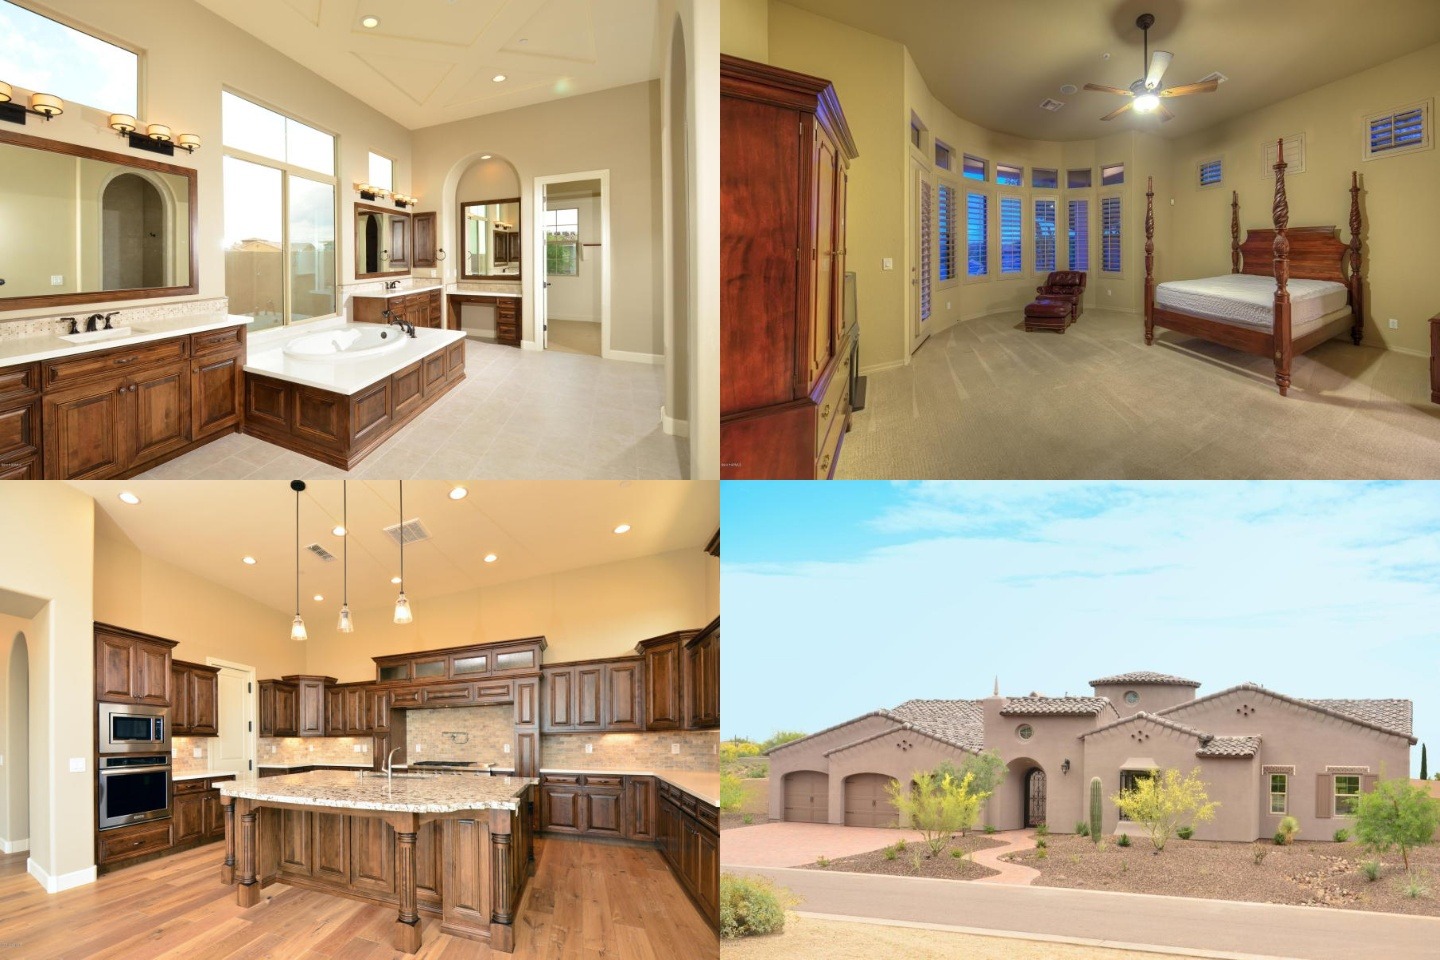

In [11]:
Image(filename='HousesDatasetClean/1/4.jpg')

**For every element in the HouseData dataset, there is a corresponding image in the HouseDatasetClean folder, following the same index. So, for index 0 of the dataset, there is a picture 0.jpg in the HouseDatasetClean folder.**

## Task 1: Non-Linear Structured Model in PyTorch (30 pts)

For the first task, build a model in PyTorch that takes bedrooms, bathrooms, and the area variables and predicts the price of the house. For this we first need a dataset iterator, created below. To read more about data iterators, [read this explanation](https://pytorch.org/docs/stable/data.html).

**Note 1: There was a bug in the version that was sent to you that mistakenly used StandardScaler instead of MinMaxScaler. This solution is implemented using MinMaxScaler, but for marking both were considered correct**

**Note 2: For this solution, I will also be using GPU training to speed things up quite a bit. It is fairly simple to run this on cpu, simply search for both .cuda() and .cpu() calls in the data and delete those calls (they move data back and forth the GPU and the RAM) and also comment the "model.to(device)" line that appears below.**

In [18]:
# Data iterators. Run first.
class StructuredDataset(Dataset):
    def __init__(self, x, y):
        super(StructuredDataset, self).__init__()
        assert x.shape[0] == y.shape[0]
        if torch.cuda.is_available():
            device = 'cuda'
        else:
            device = 'cpu'
        self.x_data = torch.as_tensor(x, device=device, dtype=torch.float)
        self.y_data = torch.as_tensor(y, device=device, dtype=torch.float)


    def __len__(self):
        return self.y_data.shape[0]

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]


# Load data into 'flattened' NumPy arrays [5 pts]
train, test = train_test_split(HouseData, 
                               test_size = 0.3,
                               random_state = 20201207)


# Normalize the data
normalizer = MinMaxScaler()
train = normalizer.fit_transform(train)
test = normalizer.transform(test)

# Define the dataset
traindata = StructuredDataset(train[:, :-1], train[:, -1])

# Create iterator. Pass this to the enumerate function.
batch_size = 32
trainloader = torch.utils.data.DataLoader(traindata, batch_size=batch_size, 
                                          shuffle=True)

This has created a `trainloader` object that shuffles the dataset and pulls examples. We can use this to train our neural network. Now we can start creating the model, you'll take it from here. First:

a. Create a model in PyTorch that predicts the price of the house using the other varibles. Use the following architecture:

- [ReLU activation functions](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html) in all layers, including the output layer.
- SGD optimizer with a learning rate of 0.01
- Mean square error loss function ([MSELoss](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html)).
- Two hidden layers with 1024 neurons each
- One output layer with an adequate number of neurons in the output layer for a regression problem.

You should see something like this after creating your model.

![imagen.png](attachment:1d617aff-c832-48bd-a0f9-fa3e5e4b4f44.png)

In [19]:
# Define the architecture [20 pts]
class NonLinearModel(torch.nn.Module):
    
    def __init__(self, input_size, hidden_size = 1024, num_classes=1):
        
        super().__init__()
        
        # Neural Network Architecture
        self.dense1 = torch.nn.Linear(in_features=num_features, out_features=hidden_size)
        self.activation1 = torch.nn.ReLU()
        self.dense2 = torch.nn.Linear(in_features=hidden_size, out_features=hidden_size)
        self.activation2 = torch.nn.ReLU()
        self.dense3 = torch.nn.Linear(in_features=hidden_size, out_features=num_classes)
        self.activation3 = torch.nn.ReLU()

    def forward(self, X):
        X = self.dense1(X)
        X = self.activation1(X)
        X = self.dense2(X)
        X = self.activation2(X)
        X = self.dense3(X)
        X = self.activation3(X)
        return X

In [20]:
#Initiate the model first.
num_features = 3
model = NonLinearModel(num_features, 1024, 1)

# If you have GPU, run these:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

NonLinearModel(
  (dense1): Linear(in_features=3, out_features=1024, bias=True)
  (activation1): ReLU()
  (dense2): Linear(in_features=1024, out_features=1024, bias=True)
  (activation2): ReLU()
  (dense3): Linear(in_features=1024, out_features=1, bias=True)
  (activation3): ReLU()
)

b. Train the model until you obtain convergence. Plot the error over the train set as you train. **Written answer: Can the model capture the price variations with the data you have? Why? Why not?**

In [21]:
# Train! [10 pts]
max_iter = 100
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
criterion = torch.nn.MSELoss()

loss_list = []
mse_list = []
valid_list = []

for i in range(max_iter):
    epoch_loss = 0
    for index, (data, label) in enumerate(trainloader):
        optimizer.zero_grad()
        y_pred = model(data.cuda())
        loss = criterion(input=y_pred.cuda(), target=label.reshape(-1, 1).cuda())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"Batch %i loss: %0.3f" % (index+1, loss.item()), end='\r')

    with torch.no_grad():
        loss_list.append(epoch_loss)
        y_pred = model.forward(torch.Tensor(train[:, :-1]).cuda())
        mse_list.append(mean_squared_error(y_true=train[:, -1], 
                                           y_pred=y_pred.cpu()))
        y_pred_val = model.forward(torch.Tensor(test[:, :-1]).cuda())
        valid_list.append(mean_squared_error(y_true=test[:, -1], 
                                             y_pred=y_pred_val.cpu()))
        live_plot(np.array(loss_list), np.array(mse_list), valid_list)

AssertionError: Torch not compiled with CUDA enabled

**Written answer: The model is able to learn some patterns over the train set (as we have a constantly decaying training loss and training MSE), but these patterns do not easily translate to the test set.**

## Task 2: Tweaking the model. [45 pts]

Now, repeat Task 1, but modify the following parameters:

a. Number of hidden layers. Try using just one and the two you used above.

b. Neurons in the hidden layer. Try 512, 1024 and 2048 (keep the same number in each layer).

c. Learning rate. Reduce it to $10^{-4}$ and increase it to $10^{-1}$.

**Written answer: Can you beat the original model in test set MSE? What combination of parameters leads to a better solution? Why do you think this is? What parameters are more important?**

*Note: You are in fact doing a gridsearch for the best parameters. You should in theory do this using cross-validation as we did in the last assignment, but for neural networks this can be infeasible without using GPUs so we will ignore it for this assignment. Just use the iterator we already have defined.*

In [46]:
# Set the parameters to iterate to
learning_rate = [0.0001, 0.1]
hidden_size = [512, 1024, 2048]



Double-layer net. LR: 0.0001, HS: 512. MSE test set=0.003


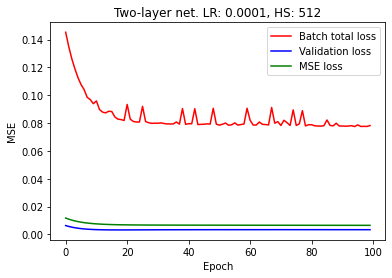

Double-layer net. LR: 0.0001, HS: 1024. MSE test set=0.004


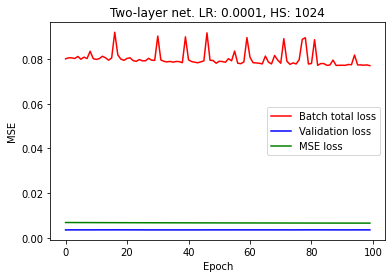

Double-layer net. LR: 0.0001, HS: 2048. MSE test set=0.003


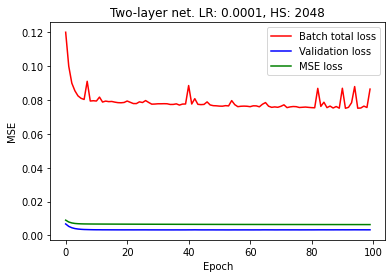

Double-layer net. LR: 0.1000, HS: 512. MSE test set=0.012


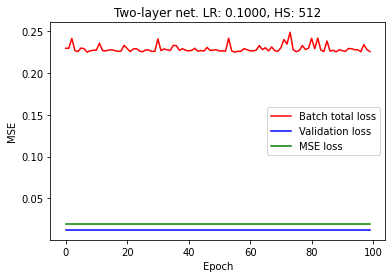

Double-layer net. LR: 0.1000, HS: 1024. MSE test set=0.012


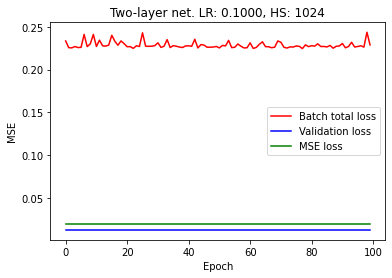

Double-layer net. LR: 0.1000, HS: 2048. MSE test set=0.012


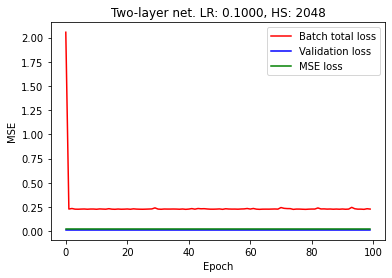

In [51]:
# Create parameter grid
param_grid = product(learning_rate, hidden_size)

# Iterate for the two layer network
for (lr, hl) in param_grid:
  model = NonLinearModel(num_features, hl, 1)
  model.to(device)
  optimizer = torch.optim.SGD(model.parameters(), lr=lr)

  loss_list = []
  mse_list = []
  valid_list = []

  for i in range(max_iter):
      epoch_loss = 0
      for index, (data, label) in enumerate(trainloader):
          optimizer.zero_grad()
          y_pred = model(data.cuda())
          loss = criterion(input=y_pred.cuda(), target=label.reshape(-1, 1).cuda())
          loss.backward()
          optimizer.step()
          epoch_loss += loss.item()
          print(f"Batch %i loss: %0.3f" % (index+1, loss.item()), end='\r')

      with torch.no_grad():
          loss_list.append(epoch_loss)
          y_pred = model.forward(torch.Tensor(train[:, :-1]).cuda())
          mse_list.append(mean_squared_error(y_true=train[:, -1], 
                                            y_pred=y_pred.cpu()))
          y_pred_val = model.forward(torch.Tensor(test[:, :-1]).cuda())
          valid_list.append(mean_squared_error(y_true=test[:, -1], 
                                              y_pred=y_pred_val.cpu()))
        
  print('Double-layer net. LR: %.4f, HS: %i. MSE test set=%.3f' % (lr, hl, valid_list[-1]))
  plt.plot(loss_list, color="red", label = "Batch total loss")
  plt.plot(valid_list, color="blue", label = "Validation loss")
  plt.plot(mse_list, color="green", label = "MSE loss")
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.title('Two-layer net. LR: %.4f, HS: %i' % (lr, hl))
  plt.legend()
  plt.savefig('Model_lr'+str(lr)+'_hl'+str(hl)+'_twolayers.pdf')
  plt.show()

Single-layer net. LR: 0.0001, HS: 512. MSE test set=0.012


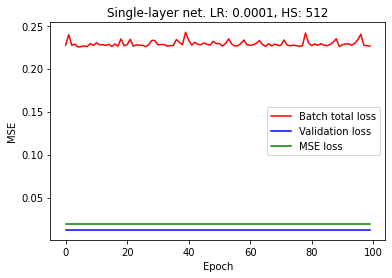

Single-layer net. LR: 0.0001, HS: 1024. MSE test set=0.012


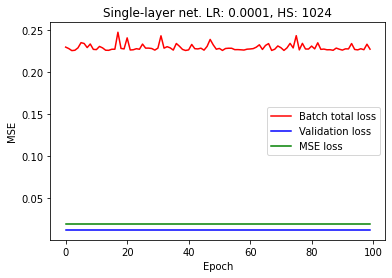

Single-layer net. LR: 0.0001, HS: 2048. MSE test set=0.004


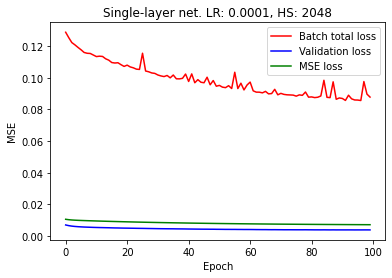

Single-layer net. LR: 0.1000, HS: 512. MSE test set=0.012


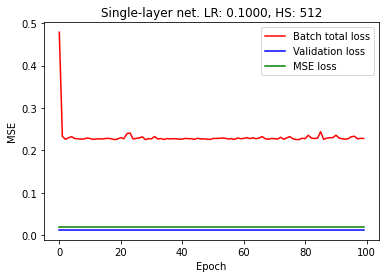

Single-layer net. LR: 0.1000, HS: 1024. MSE test set=0.012


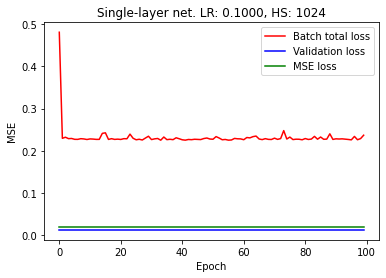

Single-layer net. LR: 0.1000, HS: 2048. MSE test set=0.012


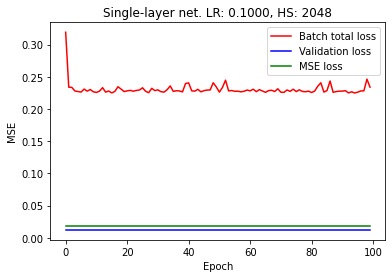

In [52]:
# Create class
class NonLinearModel(torch.nn.Module):
    
    def __init__(self, input_size, hidden_size = 1024, num_classes=1):
        
        super().__init__()
        
        # Neural Network Architecture
        self.dense1 = torch.nn.Linear(in_features=num_features, out_features=hidden_size)
        self.activation1 = torch.nn.ReLU()
        self.dense2 = torch.nn.Linear(in_features=hidden_size, out_features=num_classes)
        self.activation2 = torch.nn.ReLU()

    def forward(self, X):
        X = self.dense1(X)
        X = self.activation1(X)
        X = self.dense2(X)
        X = self.activation2(X)
        return X

# Create parameter grid
param_grid = product(learning_rate, hidden_size)

# Iterate for the two layer network
for (lr, hl) in param_grid:
  model = NonLinearModel(num_features, hl, 1)
  model.to(device)
  optimizer = torch.optim.SGD(model.parameters(), lr=lr)

  loss_list = []
  mse_list = []
  valid_list = []

  for i in range(max_iter):
      epoch_loss = 0
      for index, (data, label) in enumerate(trainloader):
          optimizer.zero_grad()
          y_pred = model(data.cuda())
          loss = criterion(input=y_pred.cuda(), target=label.reshape(-1, 1).cuda())
          loss.backward()
          optimizer.step()
          epoch_loss += loss.item()
          print(f"Batch %i loss: %0.3f" % (index+1, loss.item()), end='\r')

      with torch.no_grad():
          loss_list.append(epoch_loss)
          y_pred = model.forward(torch.Tensor(train[:, :-1]).cuda())
          mse_list.append(mean_squared_error(y_true=train[:, -1], 
                                            y_pred=y_pred.cpu()))
          y_pred_val = model.forward(torch.Tensor(test[:, :-1]).cuda())
          valid_list.append(mean_squared_error(y_true=test[:, -1], 
                                              y_pred=y_pred_val.cpu()))
        
  print('Single-layer net. LR: %.4f, HS: %i. MSE test set=%.3f' % (lr, hl, valid_list[-1]))
  plt.plot(loss_list, color="red", label = "Batch total loss")
  plt.plot(valid_list, color="blue", label = "Validation loss")
  plt.plot(mse_list, color="green", label = "MSE loss")
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.title('Single-layer net. LR: %.4f, HS: %i' % (lr, hl))
  plt.legend()
  plt.savefig('Model_lr'+str(lr)+'_hl'+str(hl)+'_twolayers.pdf')
  plt.show()

**Written answer: We can clearly see the effects of the parameters. A high learning rate causes the model to never learn anything: The very aggressive change in parameters does not give the chance to the network to get stable patterns. The hidden layer size is actually counter-productive: Smaller sizes lead to better prediction. This dataset is fairly simple, so it makes sense we don't need a very complex model before we overfit. The number of hidden layers is relevant though: a more complex number of hidden layers does lead to a better model. This is normally the case, it is better to go deep than to go wide!**

## Task 3: Convolutional Neural Network [25 pts]

Now we will train a custom convolutional neural network that takes the images, creates a train / test split, and calculates the price of the house given the images. As image datasets can be very large, we cannot simply load them into memory. We must create iterators that load, on demand, the images we need. For this we use the [``ImageFolder``](https://pytorch.org/vision/stable/datasets.html#imagefolder) class, that does exactly that. However, as this is a regression problem, we need to extend this class to be able to handle regression data. I do this when I create the ``RegressionImageFolder`` below. Then, I simply load the dataset, as follows:

In [7]:
# How we will transform the images.
transform = torchvision.transforms.Compose([torchvision.transforms.Resize(255),   # Scale images from 0-255 to 0-1
                                            torchvision.transforms.ToTensor()])   # Transform everything to a pytorch tensor

# Add path to images.
ImagePath = 'HousesDatasetClean/1' # This works on Windows. In OSX or Linux (Colab), use 'HousesDatasetClean/1'
HouseData['path'] = [os.path.join(ImagePath, str(i) + '.jpg') for i in HouseData.index.values]   # Create the image path
HouseData.head()  # See what comes out

# Read the data from the folder
class RegressionImageFolder(torchvision.datasets.ImageFolder):
    def __init__(
        self, root: str, image_scores: Dict[str, float], **kwargs: Any
    ) -> None:
        super().__init__(root, **kwargs)
        paths, _ = zip(*self.imgs)
        self.targets = [image_scores[path] for path in paths]
        self.samples = self.imgs = list(zip(paths, self.targets))

# In Torch I can't see the labels, so I'll normalize the whole thing.
HouseData['price'] = (HouseData['price'] - np.mean(HouseData['price'])) / np.std(HouseData['price'])

# Create the data loader
img_dataset = RegressionImageFolder('HousesDatasetClean', transform=transform,
                                   image_scores = dict(zip(HouseData['path'], HouseData['price'])))

# Create the dataloaders
dataset_train, dataset_valid = torch.utils.data.random_split(img_dataset, (375, 160))

batch_size = 16
train_loader = torch.utils.data.DataLoader(dataset=dataset_train, shuffle=True, batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(dataset=dataset_valid, shuffle=False, batch_size=batch_size)

KeyError: 'HousesDatasetClean\\1\\0.jpg'

a. Now we can train our convolutional neural network. The following code creates a convolutional architecture that you are asked to complete. Write the final layers so it has two ReLU layers,  with 1024 neurons (note the output size from the last convolutional layer is 23940, this is your input size for the first dense layer) and one output layer of sufficient size. You may do this as the model in the previous tasks, or reading about the [Sequential class](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) in pytorch here. [15 pts]

In [55]:
class ConvNet(torch.nn.Module):

    def __init__(self):
        super(ConvNet, self).__init__()

        self.cnn_layers = torch.nn.Sequential(
            # Defining a 2D convolution layer
            torch.nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            torch.nn.Conv2d(64, 4, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(4),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # COMPLETE HERE
        self.linear_layers = torch.nn.Sequential(
            torch.nn.Linear(23940, 1024),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(1024, 1),
            torch.nn.ReLU(inplace=True)
        )

    # Defining the forward pass
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        # COMPLETE HERE
        x = self.linear_layers(x)

        # Return model
        return x

b. Initiate the model with an SGD optimizer with a learning rate of 0.001 and an MSE loss. [10 pts] The models should look like this:
![imagen.png](attachment:1f588236-71df-43e1-8ebc-d198abe8ad8b.png)

In [59]:
# defining the model
model = ConvNet()

# defining the optimizer. You want a tiny learning rate for complex data!
optimizer = torch.optim.SGD(model.parameters(), lr=0.00001)
# defining the loss function
criterion = torch.nn.MSELoss()

# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

print(model)

ConvNet(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=23940, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1024, out_features=1, bias=True)
    (3): ReLU(inplace=True)
  )
)


c. Train the model using the dataset above for 10 epochs, and calculate the test set data (read [this](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) to learn to apply the model after it is trained). Plot the train and test losses.

**Written answer: What can you say about the model? Is it able to predict the prices? How does it compare with the structured data model? Discuss your results.**  [15 pts]

**Hint: If you run out of memory while training, reduce the batch size and restart the notebook kernel running only starting from Task 3**

In [64]:
# Train! [10 pts]
max_iter = 10

valid_list = []
train_list = []


for i in range(max_iter):
    epoch_loss = 0
    for index, (data, label) in enumerate(train_loader):
        optimizer.zero_grad()
        if torch.cuda.is_available():
            data = data.to(device)
            label = label.to(device)
        y_pred = model(data)
        loss = criterion(input=y_pred, target=label.reshape(-1, 1).float())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"Batch %i loss: %0.3f" % (index+1, loss.item()), end='\r')

    with torch.no_grad():
        y_pred_val = []
        y_real = []
        for data in val_loader:
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()
            outputs = model(images)
            y_pred_val.append(outputs.cpu().numpy())
            y_real.append(labels.cpu().numpy())
        y_real = np.concatenate(y_real).ravel()
        y_pred_val = np.concatenate(y_pred_val).ravel()
        valid_list.append(mean_squared_error(y_true=y_real, y_pred=y_pred_val))
        train_list.append(epoch_loss)

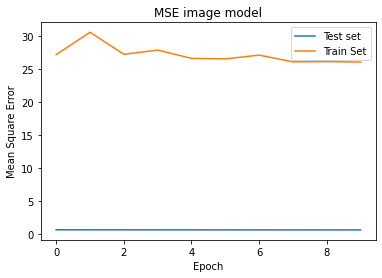

In [66]:
# Plot the losses [2 pts]
plt.plot(valid_list, label='Test set')
plt.plot(train_list, label='Train Set')

plt.title('MSE image model')
plt.xlabel('Epoch')
plt.ylabel('Mean Square Error')
plt.legend()
plt.show()

**Written answer: The model is able to learn something over the train set, but this is not translated to the test set. This makes sense, as the model is learning over only images, without any further information about location, surface area, etc. There is however some information which can be extracted by the model. In the end, good data is better than big data! [3 pts]** 